<a href="https://colab.research.google.com/github/Inthujan95/Fine_Tune_LLM/blob/main/Fine_Tune_LLM_Part_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install transformers accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 128.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [5]:
pip install transformers accelerate

In [12]:
!pip install langgraph
!pip install langchain_groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.5/152.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 11.1 MB/s eta 0:00:00


In [14]:
from typing import List, Optional, TypedDict

In [15]:
class AgentState(TypedDict, total=False):
    user_input: str
    task_list: List[str]
    final_output: Optional[str]

In [19]:
from google.colab import userdata
groq_api_key = userdata.get('Groq_Api_Key')

In [20]:
from langchain_groq import ChatGroq
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7fc7ba1d7c90>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7fc7b993be10>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [21]:
def planner_node(state: dict) -> dict:
    prompt = f"Break this task into 2-3 steps: {state['user_input']}"
    response  = llm.invoke(prompt)  # Assuming you have a function defined to call the LLM
    steps = response.content
    step_lines = [line.strip("- ").strip() for line in steps.split("\n") if line.strip()]
    print("📌 Planner Output:", step_lines)
    return {"task_list": step_lines}

In [22]:
def executor_node(state: dict) -> dict:
    steps = state.get("task_list", [])
    final_output = " -> ".join(steps) + " -> Done!"
    return {"final_output": final_output}

In [23]:
import langgraph.graph

In [24]:
from langgraph.graph import StateGraph

In [25]:
graph = StateGraph(state_schema=AgentState)

In [26]:
graph.add_node("planner", planner_node)
graph.add_node("executor", executor_node)

graph.set_entry_point("planner")
graph.add_edge("planner", "executor")
graph.set_finish_point("executor")

In [27]:
graph_compiled = graph.compile()

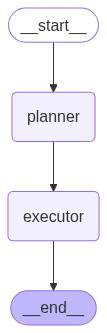

In [28]:
from IPython.display import Image, display
try:
    display(Image(graph_compiled.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [29]:
state = {"user_input": "How do solar panels work?"}
final_state = graph_compiled.invoke(state)

📌 Planner Output: ["Here's a breakdown of how solar panels work into 3 steps:", '**Step 1: Solar Energy Absorption**', 'Solar panels are made up of many small photovoltaic (PV) cells, which are made from semiconducting materials like silicon. These cells are arranged in a grid-like pattern on the surface of the panel. When sunlight hits the PV cells, it excites the electrons in the material, causing them to flow through the material and create an electrical current. This process is known as the photovoltaic effect.', '**Step 2: Conversion to Direct Current (DC) Electricity**', 'The electrical current generated by the PV cells is in the form of direct current (DC) electricity. DC electricity is the type of electricity that flows in one direction only, like the flow of water through a hose. The DC electricity is collected from each PV cell and sent through a network of metal wires on the surface of the panel.', '**Step 3: Conversion to Alternating Current (AC) Electricity and Powering De

In [30]:
print(final_state["final_output"])

Here's a breakdown of how solar panels work into 3 steps: -> **Step 1: Solar Energy Absorption** -> Solar panels are made up of many small photovoltaic (PV) cells, which are made from semiconducting materials like silicon. These cells are arranged in a grid-like pattern on the surface of the panel. When sunlight hits the PV cells, it excites the electrons in the material, causing them to flow through the material and create an electrical current. This process is known as the photovoltaic effect. -> **Step 2: Conversion to Direct Current (DC) Electricity** -> The electrical current generated by the PV cells is in the form of direct current (DC) electricity. DC electricity is the type of electricity that flows in one direction only, like the flow of water through a hose. The DC electricity is collected from each PV cell and sent through a network of metal wires on the surface of the panel. -> **Step 3: Conversion to Alternating Current (AC) Electricity and Powering Devices** -> The DC el